# Notebook para solução do Case Geofusion

### 1. Setup

In [292]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler

In [2]:
warnings.filterwarnings("ignore")

In [235]:
# Params
DATA_DIR = 'data'
DATA_FILENAME = 'DadosDesafioCientista.csv'
NUM_COLS = ['população', 'popAte9', 'popDe10a14', 'popDe15a19', 'popDe20a24', 'popDe25a34', 'popDe35a49',
            'popDe50a59', 'popMaisDe60', 'domiciliosA1', 'domiciliosA2', 'domiciliosB1', 'domiciliosB2',
            'domiciliosC1', 'domiciliosC2', 'domiciliosD', 'domiciliosE', 'rendaMedia', 'faturamento']
POP_COLS = ['popAte9', 'popDe10a14', 'popDe15a19', 'popDe20a24', 'popDe25a34', 'popDe35a49',
            'popDe50a59', 'popMaisDe60']
DOM_COLS = ['domiciliosA1', 'domiciliosA2', 'domiciliosB1', 'domiciliosB2',
            'domiciliosC1', 'domiciliosC2', 'domiciliosD', 'domiciliosE']
# Colunas para fit do imputer
IMP_COLS = ['população', 'popAte9', 'popDe10a14', 'popDe15a19', 'popDe20a24', 'popDe25a34', 'popDe35a49',
            'popDe50a59', 'popMaisDe60', 'domiciliosA1', 'domiciliosA2', 'domiciliosB1', 'domiciliosB2',
            'domiciliosC1', 'domiciliosC2', 'domiciliosD', 'domiciliosE', 'rendaMedia']
# Utilizarei as colunas de pop e dom para treinar os modelos
TRAIN_COLS = POP_COLS + DOM_COLS + ["rendaMedia"]

In [4]:
# Leitura dados
df = pd.read_csv(os.path.join(DATA_DIR, DATA_FILENAME))

In [5]:
df.head()

,codigo,nome,cidade,estado,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,...,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial
0,3304557060,Abolição,Rio de Janeiro,RJ,11676,1027,483,688,800,1675,...,145,715,1242,1093,758,92,304,2501,932515.0,Médio
1,3304557138,Acari,Rio de Janeiro,RJ,27564,5131,2188,2697,2630,4810,...,0,82,506,2040,2490,827,2506,931,588833.0,Baixo
2,3304557057,Água Santa,Rio de Janeiro,RJ,9003,883,399,597,762,1755,...,96,404,652,644,522,77,254,2391,874200.0,Baixo
3,3304557031,Alto Da Boa Vista,Rio de Janeiro,RJ,9606,1072,538,660,685,1317,...,178,393,517,945,584,137,286,3727,912226.0,Médio
4,3304557125,Anchieta,Rio de Janeiro,RJ,57222,7677,3774,4892,4600,8660,...,0,1089,2821,5110,5422,1073,3261,1380,553020.0,Médio


### 2. Exploração

In [6]:
# Obtendo tamanho do dataframe
df.shape

(456, 24)

In [7]:
# Obtendo nomes de todas colunas
df.columns

Index(['codigo', 'nome', 'cidade', 'estado', 'população', 'popAte9',
       'popDe10a14', 'popDe15a19', 'popDe20a24', 'popDe25a34', 'popDe35a49',
       'popDe50a59', 'popMaisDe60', 'domiciliosA1', 'domiciliosA2',
       'domiciliosB1', 'domiciliosB2', 'domiciliosC1', 'domiciliosC2',
       'domiciliosD', 'domiciliosE', 'rendaMedia', 'faturamento', 'potencial'],
      dtype='object')

In [28]:
# Verificando campos nulos nas colunas
df.isna().sum()

codigo            0
nome              0
cidade            0
estado            0
população         0
popAte9           0
popDe10a14        0
popDe15a19        0
popDe20a24        0
popDe25a34        0
popDe35a49        0
popDe50a59        0
popMaisDe60       0
domiciliosA1      0
domiciliosA2      0
domiciliosB1      0
domiciliosB2      0
domiciliosC1      0
domiciliosC2      0
domiciliosD       0
domiciliosE       0
rendaMedia        6
faturamento     296
potencial       296
dtype: int64

In [23]:
# Obtendo tipos de dado presente em cada coluna
df.dtypes

codigo            int64
nome             object
cidade           object
estado           object
população         int64
popAte9           int64
popDe10a14        int64
popDe15a19        int64
popDe20a24        int64
popDe25a34        int64
popDe35a49        int64
popDe50a59        int64
popMaisDe60       int64
domiciliosA1      int64
domiciliosA2      int64
domiciliosB1      int64
domiciliosB2      int64
domiciliosC1      int64
domiciliosC2      int64
domiciliosD       int64
domiciliosE       int64
rendaMedia       object
faturamento     float64
potencial        object
dtype: object

In [27]:
# Verificando tipo de dados da variavel rendaMedia
df_teste_renda = df.copy()
df_teste_renda['tipo_renda'] = df_teste_renda['rendaMedia'].map(lambda s: type(s))
df_teste_renda['tipo_renda'].value_counts()

<class 'str'>      450
<class 'float'>      6
Name: tipo_renda, dtype: int64

In [153]:
# Verificando valores presentes em rendaMedia
df_teste_renda.rendaMedia.unique()

array(['2501', '931', '2391', '3727', '1380', '3443', nan, '1962', '1550',
       '18084', '1479', '895', '1294', '2048', '1944', '8316', '1874',
       '2963', '2022', '1037', '2929', '2377', '5876', '1856', '1796',
       '4283', '1499', '2186', '1244', '1809', '1934', '2927', '1425',
       '1221', '1010', '7381', '1480', '8425', '1308', '925', '1892',
       '1889', '1416', '2342', '1517', '1620', '2260', '2325', '1631',
       '10619', '2125', '1740', '1133', '1837', '16449', '1225', '4011',
       '6194', '654', '1483', '1237', '2336', '1403', '9504', '1329',
       '1227', '17188', '2140', '4313', '2160', '1023', '1574', '17984',
       '1943', '6499', '3039', '17659', '63887', '8980', '14738', '8861',
       '2038', '1848', '1045', '1039', '1107', '1675', '2612', '4671',
       '3669', '2104', '1952', '1241', '1602', '1696', '1113', '1679',
       '1374', '1384', '3089', '1522', '1682', '2005', '1535', '1688',
       '2511', '5324', '2162', '2699', '2053', '1576', '8407', '2541

In [148]:
df_teste_renda[df_teste_renda.rendaMedia=='-']

,codigo,nome,cidade,estado,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,...,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial,tipo_renda
232,355030170,Eta Guaraú,São Paulo,SP,0,0,0,0,0,0,...,0,0,0,0,0,0,-,NaN,NaN,<class 'str'>
361,355030227,Pico Do Jaraguá,São Paulo,SP,0,0,0,0,0,0,...,0,0,0,0,0,0,-,NaN,NaN,<class 'str'>
376,355030167,Reserva Da Cantareira,São Paulo,SP,0,0,0,0,0,0,...,0,0,0,0,0,0,-,NaN,NaN,<class 'str'>


In [149]:
df_teste_renda[df_teste_renda.rendaMedia.isna()]

,codigo,nome,cidade,estado,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,...,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial,tipo_renda
6,3304557082,Anil,Rio de Janeiro,RJ,24855,2427,1227,1777,1804,3730,...,1771,1863,1902,1155,326,424,NaN,1092081.0,Baixo,<class 'float'>
26,3304557005,Catumbi,Rio de Janeiro,RJ,12910,1773,805,1018,999,1985,...,261,640,1281,1140,229,703,NaN,791170.0,Baixo,<class 'float'>
52,3304557086,Freguesia (Jacarepaguá),Rio de Janeiro,RJ,72501,7991,3709,5257,5159,10923,...,6042,4941,5055,3919,704,1670,NaN,1297388.0,Médio,<class 'float'>
71,3304557146,Jacaré,Rio de Janeiro,RJ,9538,1326,629,763,712,1547,...,161,492,633,792,197,540,NaN,822849.0,Baixo,<class 'float'>
89,3304557032,Maracanã,Rio de Janeiro,RJ,25969,1696,843,1370,1921,4020,...,3191,1924,1522,877,0,497,NaN,1384873.0,Baixo,<class 'float'>
122,3304557006,Rio Comprido,Rio de Janeiro,RJ,44998,5332,2397,3448,3757,7160,...,2119,2775,3715,3930,617,1681,NaN,789463.0,Baixo,<class 'float'>


- Valores numéricos como string, alguns valores em float (NaN) e outros com "-"
- Os valores NaN estão na parte de RJ, enquanto que os valores "-" estão na base de SP

In [8]:
# Verificando qtde presente de casa estado
df.estado.value_counts()

SP    296
RJ    160
Name: estado, dtype: int64

In [9]:
# Separando em RJ e SP
df_sp = df[df.estado=="SP"]
df_rj = df[df.estado=="RJ"]

In [10]:
# Verificando campos nulos nas colunas - SP
df_sp.isna().sum()

codigo            0
nome              0
cidade            0
estado            0
população         0
popAte9           0
popDe10a14        0
popDe15a19        0
popDe20a24        0
popDe25a34        0
popDe35a49        0
popDe50a59        0
popMaisDe60       0
domiciliosA1      0
domiciliosA2      0
domiciliosB1      0
domiciliosB2      0
domiciliosC1      0
domiciliosC2      0
domiciliosD       0
domiciliosE       0
rendaMedia        0
faturamento     296
potencial       296
dtype: int64

In [11]:
# Verificando campos nulos nas colunas - RJ
df_rj.isna().sum()

codigo          0
nome            0
cidade          0
estado          0
população       0
popAte9         0
popDe10a14      0
popDe15a19      0
popDe20a24      0
popDe25a34      0
popDe35a49      0
popDe50a59      0
popMaisDe60     0
domiciliosA1    0
domiciliosA2    0
domiciliosB1    0
domiciliosB2    0
domiciliosC1    0
domiciliosC2    0
domiciliosD     0
domiciliosE     0
rendaMedia      6
faturamento     0
potencial       0
dtype: int64

In [12]:
# Bairros de RJ sem renda anotada na base
df_rj[df_rj.rendaMedia.isnull()]

,codigo,nome,cidade,estado,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,...,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial
6,3304557082,Anil,Rio de Janeiro,RJ,24855,2427,1227,1777,1804,3730,...,759,1771,1863,1902,1155,326,424,NaN,1092081.0,Baixo
26,3304557005,Catumbi,Rio de Janeiro,RJ,12910,1773,805,1018,999,1985,...,18,261,640,1281,1140,229,703,NaN,791170.0,Baixo
52,3304557086,Freguesia (Jacarepaguá),Rio de Janeiro,RJ,72501,7991,3709,5257,5159,10923,...,2569,6042,4941,5055,3919,704,1670,NaN,1297388.0,Médio
71,3304557146,Jacaré,Rio de Janeiro,RJ,9538,1326,629,763,712,1547,...,15,161,492,633,792,197,540,NaN,822849.0,Baixo
89,3304557032,Maracanã,Rio de Janeiro,RJ,25969,1696,843,1370,1921,4020,...,1695,3191,1924,1522,877,0,497,NaN,1384873.0,Baixo
122,3304557006,Rio Comprido,Rio de Janeiro,RJ,44998,5332,2397,3448,3757,7160,...,387,2119,2775,3715,3930,617,1681,NaN,789463.0,Baixo


In [13]:
# Validando a coluna de população (soma das outras populações)
df_rj.loc[:, "populacao_calc"] = df_rj[[*POP_COLS]].sum(axis=1)
# Se a qtde de valores corretos for igual ao tamanho do df
assert np.sum(df_rj["população"]==df_rj["populacao_calc"]) == df_rj.shape[0]

<AxesSubplot:>

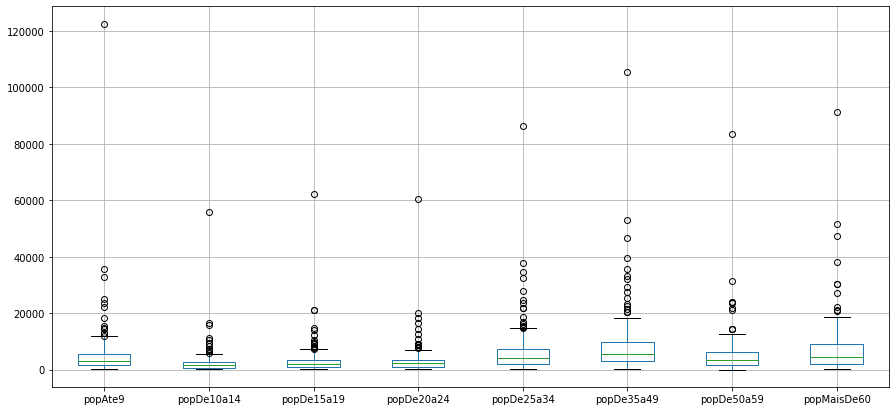

In [17]:
# Verificando distribuições das vaiaveis de populcao na base de RJ
fig, ax = plt.subplots(figsize=(15, 7))
df_rj[[*POP_COLS]].boxplot()

<AxesSubplot:>

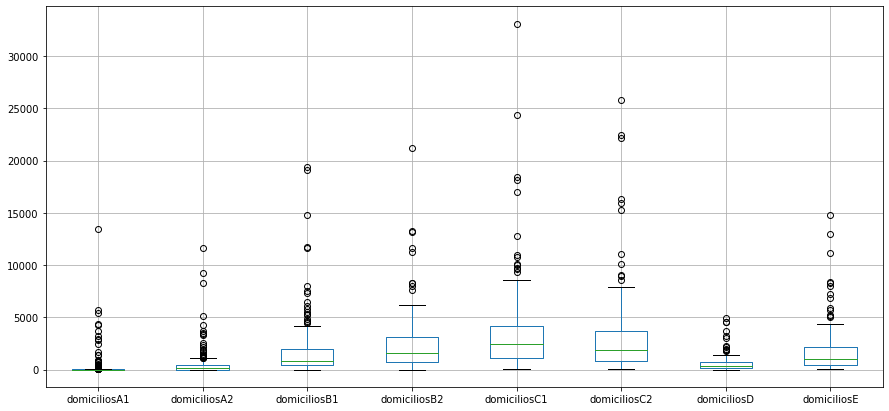

In [18]:
# Verificando distribuições das variaveis de domicilios na base de RJ
fig, ax = plt.subplots(figsize=(15, 7))
df_rj[[*DOM_COLS]].boxplot()

In [47]:
# Removendo linhas com rendaMedia nula e passando para int
df_rj_mod = df_rj.copy()
df_rj_mod.dropna(subset=["rendaMedia"], inplace=True)
df_rj_mod["rendaMedia"] = df_rj_mod["rendaMedia"].astype(int)

<AxesSubplot:>

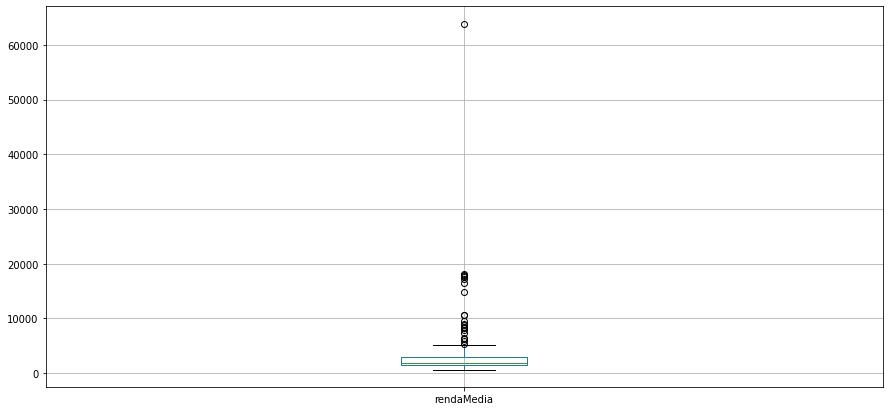

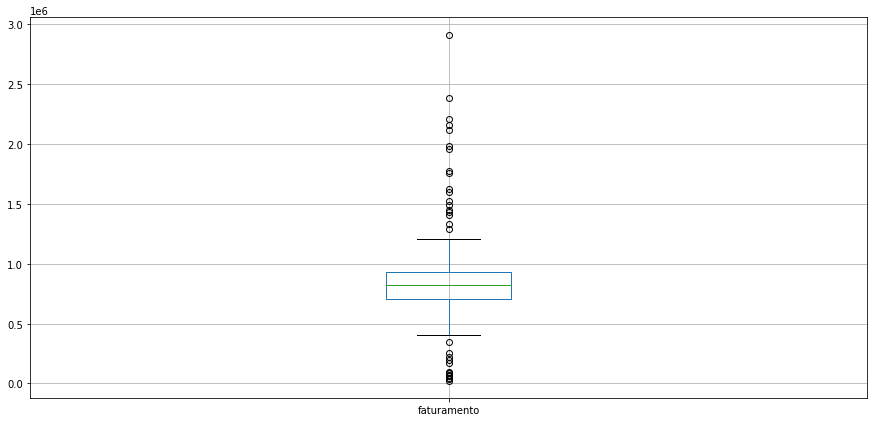

In [48]:
# Verificando distribuições das veriaveis rendaMedia e faturamento de RJ
fig, ax = plt.subplots(figsize=(15, 7))
df_rj_mod[["rendaMedia"]].boxplot()
fig, ax = plt.subplots(figsize=(15, 7))
df_rj_mod[["faturamento"]].boxplot()

- Notam-se valores outliers em várias das distribuições das variáveis presentes no dataset

<AxesSubplot:>

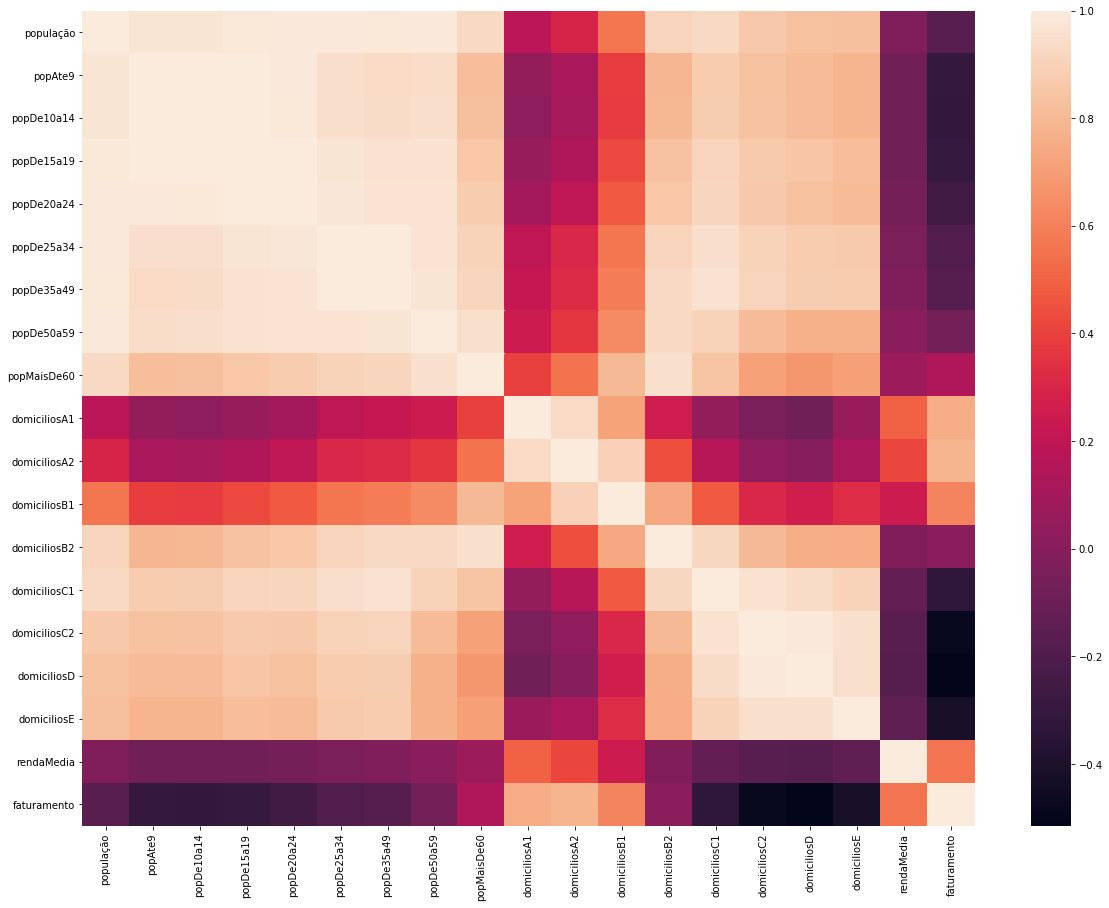

In [41]:
# Verificando correlacao entre variaveis numéricas - RJ
cor_rj = df_rj_mod[[*NUM_COLS]].corr()
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(cor_rj)

- Observações:
    - Correlação altamente negativa do faturamento com população jovem e domicilios de classe C1 para baixo
    - Alta correlação positiva de renda média e faturamento em domicilios de classe B1 pra cima
    - Correlação positiva entre renda média e faturamento considerável
    - Correlação negativa entre domicílios de alto padrao (B1, A2 e A1) e população jovem (até 19)

In [54]:
# Verificando qtde de Potencial para RJ
df_rj.potencial.value_counts()

Baixo    62
Médio    50
Alto     48
Name: potencial, dtype: int64

### 3. Processamento da base para solução do case

In [237]:
# Copia do DF para modelagem
df_model = df.copy()

In [238]:
# Inserindo NaN nos valores '-'
df_model['rendaMedia'][df_model['rendaMedia']=='-'] = np.nan

In [239]:
# Removendo linhas com rendaMedia nula
df_model.dropna(subset=["rendaMedia"], inplace=True)

In [240]:
# Transformando string em int na coluna rendaMedia
df_model["rendaMedia"] = df_model["rendaMedia"].map(lambda renda: int(renda))

In [241]:
# Separando base de treino
df_model_train = df_model[df_model.estado=='RJ'].reset_index()
# Separando base onde serão estimadas as variáveis de interesse
df_model_est = df_model[df_model.estado=='SP'].reset_index()

In [247]:
# Usando MinMaxScaler para normalizar valores das variaveis numericas
scaler = MinMaxScaler()
df_model_train[[*TRAIN_COLS]] = scaler.fit_transform(df_model_train[[*TRAIN_COLS]])
df_model_est[[*TRAIN_COLS]] = scaler.fit_transform(df_model_est[[*TRAIN_COLS]])

### 4. Solução do case

##### 1 - Estimar o faturamento que uma loja teria em cada um dos bairros

- Treinar um modelo de regressão para estimar o faturamento em SP utilizando a base de RJ como treino

##### 2- Classificar o potencial de cada bairro como Alto, Médio ou Baixo

- Treinar um modelo de classificação utilizando RJ como treino para predizer o potencial dos bairros de SP

##### 3- Segmentar os bairros de São Paulo de acordo com a renda e a idade, e indicar aqueles com maior aderência ao público alvo.

- Treinar um modelo de clusterização para obter os bairros em SP mais semelhantes nas características de renda e idade com o público alvo

##### 4.1. Estimar o faturamento que uma loja teria em cada um dos bairros

- Testando Regressão Linear Simples

In [250]:
# Treinando modelo de regressao linear
lin_reg = LinearRegression()
lin_reg.fit(df_model_train[[*TRAIN_COLS]], df_model_train['faturamento'])

LinearRegression()

In [251]:
# Métricas de desempenho do modelo (cross validation)
scores = cross_validate(lin_reg,
                        df_model_train[[*TRAIN_COLS]],  
                        df_model_train['faturamento'],
                        cv=10,
                        scoring=('r2','neg_mean_absolute_error'))

In [252]:
# Exibindo resultados
for key in scores.keys():
    print()
    print("-"*100)
    print()
    print(f"{key}: {scores[key]}")
    print()
    print(f"median({key}): {np.median(scores[key])}")
    print()


----------------------------------------------------------------------------------------------------

fit_time: [0.0048759  0.00381279 0.00716257 0.00392079 0.00404263 0.00631809
 0.01196003 0.01262355 0.00353599 0.00386977]

median(fit_time): 0.004459261894226074


----------------------------------------------------------------------------------------------------

score_time: [0.00347185 0.00326681 0.00348949 0.00315547 0.00359702 0.00360346
 0.00657535 0.01794195 0.00432134 0.0097487 ]

median(score_time): 0.0036002397537231445


----------------------------------------------------------------------------------------------------

test_r2: [ 0.73221079 -7.96581138  0.88368535  0.92198208  0.54698482  0.84587946
  0.8968607   0.65524089  0.85389683  0.91030991]

median(test_r2): 0.849888140557524


----------------------------------------------------------------------------------------------------

test_neg_mean_absolute_error: [-129211.84731315 -203309.44508066  -81752.7823424   -90

- Testando Regressão Random Forest

In [256]:
# Treinando modelo de regressao linear
rnd_forest_reg = RandomForestRegressor(random_state=42)
rnd_forest_reg.fit(df_model_train[[*TRAIN_COLS]], df_model_train['faturamento'])

RandomForestRegressor(random_state=42)

In [257]:
# Métricas de desempenho do modelo (cross validation)
scores = cross_validate(rnd_forest_reg,
                        df_model_train[[*TRAIN_COLS]],  
                        df_model_train['faturamento'],
                        cv=10,
                        scoring=('r2','neg_mean_absolute_error'))

In [258]:
# Exibindo resultados
for key in scores.keys():
    print()
    print("-"*100)
    print()
    print(f"{key}: {scores[key]}")
    print()
    print(f"median({key}): {np.median(scores[key])}")
    print()


----------------------------------------------------------------------------------------------------

fit_time: [0.35065746 0.33617234 0.30243373 0.3200531  0.36618829 0.31241488
 0.37583423 0.33500409 0.30213189 0.30259299]

median(fit_time): 0.32752859592437744


----------------------------------------------------------------------------------------------------

score_time: [0.01544094 0.01208639 0.01207614 0.01207948 0.01175165 0.01194215
 0.01199317 0.01195812 0.0120616  0.01186061]

median(score_time): 0.012027382850646973


----------------------------------------------------------------------------------------------------

test_r2: [0.90906276 0.64834906 0.96224594 0.94469955 0.87484221 0.84489987
 0.94738341 0.8954526  0.91439507 0.82624666]

median(test_r2): 0.90225768152576


----------------------------------------------------------------------------------------------------

test_neg_mean_absolute_error: [ -84497.515       -69037.245625    -66474.123125    -67171.65375
 -1

Entre os modelos de regressão testados, o Random Forest foi o que obteve melhor desempenho na validação cruzada.

In [259]:
# Utilizando o modelod de regressao com melhor desempenho para estimar os valores de faturamento em SP
df_model_est['faturamento'] = rnd_forest_reg.predict(df_model_est[[*TRAIN_COLS]])

- Testando as predições em bairros conhecidos

In [260]:
# Bairro alta renda SP
df_model_est[df_model_est.nome=="Pinheiros"]

,index,codigo,nome,cidade,estado,população,popAte9,popDe10a14,popDe15a19,popDe20a24,...,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial
200,362,355030137,Pinheiros,São Paulo,SP,12382,0.02157,0.018607,0.022859,0.042762,...,0.120477,0.203051,0.093364,0.040602,0.010655,0.0,0.040397,0.38424,1470875.36,NaN


In [379]:
# Bairro alta renda SP
df_model_est[df_model_est.nome=="Vila Olímpia"]

,index,codigo,nome,cidade,estado,população,popAte9,popDe10a14,popDe15a19,popDe20a24,...,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial,cluster
280,443,355030133,Vila Olímpia,São Paulo,SP,22235,0.034814,0.024773,0.042247,0.079801,...,0.417627,0.196796,0.05131,0.02221,0.0,0.065729,0.334687,1894366.25,Alto,0


In [383]:
# Bairro alta renda SP
df_model_est[df_model_est.nome=="Jardim São Paulo"]

,index,codigo,nome,cidade,estado,população,popAte9,popDe10a14,popDe15a19,popDe20a24,...,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial,cluster
135,296,35503099,Jardim São Paulo,São Paulo,SP,40848,0.078614,0.08131,0.10236,0.131418,...,0.501701,0.311213,0.124796,0.054932,0.073204,0.083194,0.275243,1923276.27,Alto,2


In [261]:
# Bairro baixa renda SP
df_model_est[df_model_est.nome=="Cidade Tiradentes"]

,index,codigo,nome,cidade,estado,população,popAte9,popDe10a14,popDe15a19,popDe20a24,...,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial
59,219,355030270,Cidade Tiradentes,São Paulo,SP,226226,1.0,1.0,1.0,0.991091,...,0.0,0.152453,0.917162,1.0,1.0,1.0,0.954936,0.017824,73019.36,NaN


In [384]:
# Bairro baixa renda SP
df_model_est[df_model_est.nome=="Jardim Miriam"]

,index,codigo,nome,cidade,estado,população,popAte9,popDe10a14,popDe15a19,popDe20a24,...,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial,cluster
124,285,355030196,Jardim Miriam,São Paulo,SP,140491,0.539582,0.524966,0.544451,0.64435,...,0.259467,0.719451,0.6236,0.555903,0.551347,0.647024,0.027238,75335.96,Alto,1


In [386]:
# Bairro baixa renda SP
df_model_est[df_model_est.nome=="M'Boi Mirim"]

,index,codigo,nome,cidade,estado,população,popAte9,popDe10a14,popDe15a19,popDe20a24,...,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial,cluster
155,316,355030288,M'Boi Mirim,São Paulo,SP,88421,0.387025,0.373245,0.383109,0.410993,...,0.051476,0.382838,0.386292,0.371265,0.471407,0.423438,0.015912,101228.91,Médio,1


##### 4.2. Classificar o potencial de cada bairro como Alto, Médio ou Baixo

- testando com Regressão Logística

In [271]:
# Treinando modelo de regressao logistica
log_reg_clf = LogisticRegression()
log_reg_clf.fit(df_model_train[[*TRAIN_COLS]], df_model_train['potencial'])

LogisticRegression()

In [272]:
# Métricas de desempenho do modelo (cross validation)
scores = cross_validate(log_reg_clf,
                        df_model_train[[*TRAIN_COLS]],  
                        df_model_train['potencial'],
                        cv=10,
                        scoring=('accuracy', 'recall_macro', 'precision_macro', 'f1_macro'))

In [273]:
# Exibindo resultados
for key in scores.keys():
    print()
    print("-"*100)
    print()
    print(f"{key}: {scores[key]}")
    print()
    print(f"median({key}): {np.median(scores[key])}")
    print()


----------------------------------------------------------------------------------------------------

fit_time: [0.01543522 0.01757574 0.01659346 0.04432821 0.01430869 0.01256227
 0.01241231 0.0119288  0.01146722 0.01354694]

median(fit_time): 0.013927817344665527


----------------------------------------------------------------------------------------------------

score_time: [0.00719762 0.00704122 0.01890969 0.02002668 0.00613236 0.00569987
 0.00564861 0.00561047 0.0057416  0.00574422]

median(score_time): 0.005938291549682617


----------------------------------------------------------------------------------------------------

test_accuracy: [0.75       0.75       0.625      0.75       0.66666667 0.6
 0.46666667 0.8        0.86666667 0.53333333]

median(test_accuracy): 0.7083333333333333


----------------------------------------------------------------------------------------------------

test_recall_macro: [0.73333333 0.74444444 0.6        0.73333333 0.66111111 0.57777778
 0.46

In [274]:
# Treinando modelo de random forest
rnd_forest_clf = RandomForestClassifier()
rnd_forest_clf.fit(df_model_train[[*TRAIN_COLS]], df_model_train['potencial'])

RandomForestClassifier()

In [275]:
# Métricas de desempenho do modelo (cross validation)
scores = cross_validate(rnd_forest_clf,
                        df_model_train[[*TRAIN_COLS]],  
                        df_model_train['potencial'],
                        cv=10,
                        scoring=('accuracy', 'recall_macro', 'precision_macro', 'f1_macro'))

In [276]:
# Exibindo resultados
for key in scores.keys():
    print()
    print("-"*100)
    print()
    print(f"{key}: {scores[key]}")
    print()
    print(f"median({key}): {np.median(scores[key])}")
    print()


----------------------------------------------------------------------------------------------------

fit_time: [0.29281211 0.23483372 0.26264644 0.23704076 0.24738264 0.2452085
 0.24107575 0.24040961 0.23999166 0.24908662]

median(fit_time): 0.24314212799072266


----------------------------------------------------------------------------------------------------

score_time: [0.01679039 0.01638603 0.01634979 0.01630521 0.01668739 0.01640582
 0.01966667 0.01677179 0.01700616 0.0168252 ]

median(score_time): 0.01672959327697754


----------------------------------------------------------------------------------------------------

test_accuracy: [0.875      0.9375     0.9375     0.9375     0.86666667 0.93333333
 0.6        0.93333333 0.93333333 0.93333333]

median(test_accuracy): 0.9333333333333333


----------------------------------------------------------------------------------------------------

test_recall_macro: [0.86666667 0.94444444 0.94444444 0.93333333 0.87777778 0.91666667
 

Entre os modelos de clasificação testados, o Random Forest foi o que obteve melhor desempenho na validação cruzada.

In [277]:
# Utilizando o modelo de classificação com melhor desempenho para estimar a categorização de potencial em SP
df_model_est['potencial'] = rnd_forest_clf.predict(df_model_est[[*TRAIN_COLS]])

- Testando as predições

In [289]:
# Bairro potencial alto SP
df_model_est[df_model_est.potencial=="Alto"].sample(n=10, random_state=42)

,index,codigo,nome,cidade,estado,população,popAte9,popDe10a14,popDe15a19,popDe20a24,...,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial
9,169,35503037,Alto Da Mooca,São Paulo,SP,18304,0.040777,0.035728,0.045056,0.054911,...,0.145095,0.235978,0.153432,0.053212,0.036321,0.016018,0.037731,0.195489,1545022.06,Alto
247,410,35503085,Vila Anglo Brasileira,São Paulo,SP,13812,0.032314,0.025048,0.031636,0.052427,...,0.097352,0.161343,0.152860,0.059680,0.024530,0.000000,0.027598,0.165910,1195647.17,Alto
165,326,35503026,Pacaembu,São Paulo,SP,10016,0.017146,0.015745,0.021650,0.035473,...,0.105185,0.097904,0.042792,0.013371,0.004357,0.009431,0.028865,0.683662,1519801.62,Alto
272,435,355030103,Vila Maria Alta,São Paulo,SP,53516,0.139972,0.142747,0.162551,0.215755,...,0.066020,0.296674,0.354920,0.238776,0.173415,0.088174,0.258049,0.057247,906549.28,Alto
202,364,355030156,Pirituba,São Paulo,SP,53776,0.145495,0.130966,0.147104,0.183683,...,0.162066,0.534628,0.493822,0.224970,0.128759,0.132485,0.112926,0.102786,1290090.76,Alto
280,443,355030133,Vila Olímpia,São Paulo,SP,22235,0.034814,0.024773,0.042247,0.079801,...,0.333271,0.417627,0.196796,0.051310,0.022210,0.000000,0.065729,0.334687,1894366.25,Alto
244,407,35503054,Vila Alpina,São Paulo,SP,68323,0.175144,0.168236,0.193954,0.252146,...,0.192465,0.426298,0.596911,0.305196,0.211110,0.154940,0.222052,0.075596,1278892.44,Alto
120,281,355030215,Jardim Jussara,São Paulo,SP,21892,0.061083,0.054555,0.063819,0.075968,...,0.168780,0.270113,0.151030,0.063159,0.039257,0.003443,0.047863,0.230277,1668092.54,Alto
239,402,355030233,Tremembé,São Paulo,SP,22181,0.053087,0.057803,0.064755,0.074942,...,0.120477,0.165185,0.184668,0.084357,0.045177,0.039072,0.057596,0.130358,1238534.63,Alto
236,399,355030114,Teotônio Vilela,São Paulo,SP,89182,0.329514,0.330691,0.339536,0.388964,...,0.000000,0.114697,0.501831,0.483966,0.349529,0.351497,0.287314,0.029149,116666.09,Alto


In [290]:
# Bairro potencial médio SP
df_model_est[df_model_est.potencial=="Médio"].sample(n=10, random_state=42)

,index,codigo,nome,cidade,estado,população,popAte9,popDe10a14,popDe15a19,popDe20a24,...,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial
79,240,355030267,Gleba Pêssego,São Paulo,SP,35453,0.162888,0.165153,0.159977,0.148912,...,0.000000,0.015256,0.120938,0.157408,0.169484,0.179641,0.151390,0.014957,570503.69,Médio
250,413,35503039,Vila Carioca,São Paulo,SP,27747,0.105927,0.106524,0.116130,0.133200,...,0.008579,0.040391,0.134668,0.126427,0.129895,0.093862,0.125125,0.028050,802110.86,Médio
276,439,355030195,Vila Missionária,São Paulo,SP,84503,0.335532,0.321773,0.349249,0.380271,...,0.000000,0.070025,0.351373,0.372323,0.344604,0.359731,0.448437,0.016486,104646.44,Médio
245,408,355030147,Vila Anastácio,São Paulo,SP,3409,0.006073,0.005670,0.007334,0.010961,...,0.019396,0.035671,0.025629,0.012556,0.006819,0.000150,0.013066,0.171071,996438.44,Médio
107,268,355030290,Jardim Capela,São Paulo,SP,101574,0.497925,0.483017,0.467018,0.443875,...,0.000000,0.038196,0.278833,0.404555,0.430317,0.528293,0.544630,0.009653,78522.42,Médio
141,302,355030269,Juscelino Kubitschek,São Paulo,SP,45549,0.187344,0.187779,0.193485,0.198693,...,0.000000,0.048732,0.208467,0.211382,0.179050,0.176347,0.210319,0.020691,707499.27,Médio
139,300,355030210,Jockey Clube,São Paulo,SP,4298,0.008216,0.008203,0.009401,0.014632,...,0.026110,0.019866,0.007780,0.005055,0.003457,0.004641,0.012599,0.900033,1178803.75,Médio
133,294,355030258,Jardim Romano,São Paulo,SP,35132,0.147364,0.147977,0.149444,0.157281,...,0.000000,0.040610,0.115561,0.142407,0.147038,0.119760,0.194320,0.016295,612767.87,Médio
173,334,355030294,Parelheiros,São Paulo,SP,87201,0.361141,0.385246,0.380573,0.372442,...,0.000000,0.050818,0.287872,0.344983,0.346545,0.384880,0.500833,0.012137,96162.49,Médio
113,274,355030262,Jardim Das Oliveiras,São Paulo,SP,81544,0.321243,0.333333,0.358923,0.357972,...,0.000000,0.089123,0.341304,0.324383,0.326325,0.340868,0.406440,0.018971,123540.86,Médio


In [288]:
# Bairro potencial baixo SP
df_model_est[df_model_est.potencial=="Baixo"].sample(n=10, random_state=42)

,index,codigo,nome,cidade,estado,população,popAte9,popDe10a14,popDe15a19,popDe20a24,...,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial
12,172,355030230,Anhanguera,São Paulo,SP,14818,0.056632,0.062758,0.063897,0.063765,...,0.000000,0.030403,0.097712,0.073649,0.060946,0.038772,0.038797,0.036890,922476.94,Baixo
39,199,355030237,Cantareira,São Paulo,SP,613,0.001539,0.001652,0.002028,0.001296,...,0.000000,0.000988,0.002288,0.002011,0.001799,0.001647,0.001600,0.029388,898939.19,Baixo
97,258,355030295,Jaceguava,São Paulo,SP,3549,0.013024,0.012221,0.014316,0.014308,...,0.000000,0.013171,0.017849,0.012991,0.010323,0.012874,0.020265,0.031347,892809.36,Baixo
14,174,3550309,Armênia,São Paulo,SP,7700,0.027011,0.023892,0.024693,0.038281,...,0.007833,0.032598,0.042449,0.024133,0.015059,0.013323,0.043930,0.049935,955046.48,Baixo
65,225,355030128,Congonhas,São Paulo,SP,956,0.003023,0.002367,0.001872,0.003240,...,0.002797,0.006476,0.003890,0.003044,0.002320,0.001198,0.003800,0.180007,977489.59,Baixo
184,345,355030243,Parque Ecológico Tietê,São Paulo,SP,11350,0.049735,0.049271,0.047162,0.052805,...,0.000186,0.010866,0.046339,0.039950,0.052801,0.042964,0.049930,0.019926,757083.72,Baixo
25,185,355030293,Bororé,São Paulo,SP,13537,0.061908,0.063969,0.061283,0.060472,...,0.000000,0.008671,0.052174,0.053321,0.049060,0.072605,0.071729,0.014527,712080.08,Baixo
152,313,355030298,Marcilac,São Paulo,SP,5809,0.022120,0.025929,0.025122,0.025647,...,0.000000,0.001866,0.014989,0.017719,0.023772,0.027096,0.038797,0.006355,768381.25,Baixo
181,342,355030186,Parque Do Carmo,São Paulo,SP,2039,0.011129,0.009083,0.009245,0.011069,...,0.000000,0.000439,0.004233,0.003479,0.006109,0.010928,0.014532,0.000000,814915.94,Baixo
225,388,35503089,Santa Marina,São Paulo,SP,2281,0.010084,0.009028,0.010181,0.008261,...,0.002051,0.006915,0.008696,0.006359,0.010181,0.005240,0.011133,0.040617,932216.26,Baixo


##### 4.3. Segmentar os bairros de São Paulo de acordo com a renda e a idade, e indicar aqueles com maior aderência ao público alvo.

In [369]:
# Treinando modelo K Means
n_clusters = 5
k_means = KMeans(n_clusters=n_clusters, random_state=42)
k_means.fit(df_model_train[[*TRAIN_COLS]])

KMeans(n_clusters=5, random_state=42)

In [370]:
# Predizendo o cluster do bairro
df_model_est["cluster"] = k_means.predict(df_model_est[[*TRAIN_COLS]])

In [371]:
# Vizualindo bairros do cluster 0
df_model_est[["nome", "popDe20a24", "popDe25a34", "popDe35a49", 
       "domiciliosA1", "domiciliosA2", "domiciliosB1", "domiciliosB2", 
       "faturamento", "potencial"]][df_model_est.cluster==0].sample(n=10)

,nome,popDe20a24,popDe25a34,popDe35a49,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,faturamento,potencial
14,Armênia,0.038281,0.041125,0.030198,0.000000,0.007833,0.032598,0.042449,955046.48,Baixo
34,Campo Belo,0.029318,0.040168,0.042076,0.099255,0.116747,0.136319,0.059268,1469363.81,Alto
139,Jockey Clube,0.014632,0.014028,0.018261,0.076053,0.026110,0.019866,0.007780,1178803.75,Médio
146,Liberdade/São Joaquim,0.091194,0.099204,0.069457,0.026210,0.072361,0.191307,0.197254,1119617.73,Alto
154,Masp,0.102424,0.139291,0.097705,0.171441,0.264267,0.392822,0.276087,1852398.51,Alto
179,Parque Continental,0.077858,0.098466,0.096188,0.036952,0.126072,0.249698,0.210069,1482412.86,Alto
211,Raposo Tavares,0.081529,0.099532,0.090042,0.000000,0.000000,0.073318,0.148856,919829.27,Médio
8,Alto Da Lapa,0.040657,0.053622,0.069910,0.120166,0.153860,0.162990,0.106407,1602710.76,Alto
239,Tremembé,0.074942,0.077849,0.095873,0.027929,0.120477,0.165185,0.184668,1238534.63,Alto
52,Chácara Santo Antônio,0.016468,0.031008,0.028189,0.037668,0.077583,0.083196,0.045881,1252564.95,Alto


In [372]:
# Vizualindo bairros do cluster 1
df_model_est[["nome", "popDe20a24", "popDe25a34", "popDe35a49", 
       "domiciliosA1", "domiciliosA2", "domiciliosB1", "domiciliosB2", 
       "faturamento", "potencial"]][df_model_est.cluster==1].sample(n=10)

,nome,popDe20a24,popDe25a34,popDe35a49,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,faturamento,potencial
102,Jardim Ângela,0.373846,0.389380,0.365350,0.0,0.000000,0.123367,0.408467,105202.54,Alto
290,Vila Terezinha,0.537822,0.526155,0.523668,0.0,0.000000,0.192954,0.516362,88058.63,Alto
168,Parada De Taipas,0.616759,0.669574,0.673693,0.0,0.000000,0.330699,0.766362,82011.55,Alto
196,Pedreira,0.408941,0.405895,0.401852,0.0,0.011003,0.091428,0.362357,112763.68,Alto
173,Parelheiros,0.372442,0.390583,0.392436,0.0,0.000000,0.050818,0.287872,96162.49,Médio
124,Jardim Miriam,0.644350,0.650242,0.608786,0.0,0.012309,0.259467,0.719451,75335.96,Alto
48,Centro Empresarial,0.567032,0.597331,0.572974,0.0,0.016225,0.251893,0.651144,78305.64,Alto
84,Guarapiranga,0.351601,0.381122,0.370866,0.0,0.000000,0.185271,0.453089,99443.12,Alto
148,Limoeiro,0.543329,0.523119,0.525638,0.0,0.007087,0.194380,0.560984,78700.11,Alto
113,Jardim Das Oliveiras,0.357972,0.339313,0.359657,0.0,0.000000,0.089123,0.341304,123540.86,Médio


In [387]:
pd.set_option("max_colwidth", None)

In [389]:
# Vizualindo bairros do cluster 2
df_model_est[["nome", "popDe20a24", "popDe25a34", "popDe35a49", 
       "domiciliosA1", "domiciliosA2", "domiciliosB1", "domiciliosB2", 
       "faturamento", "potencial"]][df_model_est.cluster==2].sample(n=15)

,nome,popDe20a24,popDe25a34,popDe35a49,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,faturamento,potencial
201,Piqueri/Parque São Jorge,0.146752,0.193569,0.220585,0.119450,0.336255,0.530897,0.388101,1894261.36,Alto
50,Chácara Itaim,0.073862,0.131334,0.118507,0.578344,0.392950,0.436396,0.142449,2252283.15,Alto
135,Jardim São Paulo,0.131418,0.147166,0.171398,0.175021,0.327117,0.501701,0.311213,1923276.27,Alto
153,Marechal Deodoro,0.149452,0.189084,0.188811,0.252936,0.424655,0.528482,0.392906,2180956.78,Alto
30,Brooklin,0.073700,0.121654,0.134857,0.344314,0.416076,0.379212,0.163272,2249173.71,Alto
7,Alfredo Pujol,0.126721,0.148342,0.166434,0.222859,0.372063,0.500274,0.325057,1989024.20,Alto
150,Mandaqui,0.391232,0.425993,0.512046,0.097537,0.391458,1.000000,0.894165,1889080.61,Alto
232,Saúde,0.187463,0.255749,0.248537,0.205815,0.528907,0.829986,0.412586,1992611.05,Alto
215,Rio Pequeno,0.334701,0.373657,0.351344,0.042252,0.258859,0.574141,0.467391,1574609.91,Alto
167,Pamplona,0.089736,0.134834,0.116872,0.367087,0.467922,0.427505,0.189703,2270240.22,Alto


In [374]:
# Vizualindo bairros do cluster 3
df_model_est[["nome", "popDe20a24", "popDe25a34", "popDe35a49", 
       "domiciliosA1", "domiciliosA2", "domiciliosB1", "domiciliosB2", 
       "faturamento", "potencial"]][df_model_est.cluster==3][0:10]

,nome,popDe20a24,popDe25a34,popDe35a49,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,faturamento,potencial
59,Cidade Tiradentes,0.991091,1.000000,0.95101,0.0,0.0,0.152453,0.917162,73019.36,Alto
63,Cocaia,1.000000,0.995434,1.00000,0.0,0.0,0.173856,0.839703,70437.47,Alto


In [376]:
# Vizualindo bairros do cluster 4
df_model_est[["nome", "popDe20a24", "popDe25a34", "popDe35a49", 
       "domiciliosA1", "domiciliosA2", "domiciliosB1", "domiciliosB2", 
       "faturamento", "potencial"]][df_model_est.cluster==4].sample(n=10)

,nome,popDe20a24,popDe25a34,popDe35a49,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,faturamento,potencial
96,Jaçanã,0.170185,0.183615,0.192061,0.000000,0.085789,0.258369,0.349886,1027016.41,Alto
282,Vila Prudente,0.118298,0.140986,0.164996,0.074334,0.232935,0.340138,0.310183,1702268.70,Alto
166,Palmas Do Tremembé,0.122402,0.127916,0.137457,0.014466,0.080194,0.139941,0.196682,1016465.56,Alto
278,Vila Morro Grande,0.212138,0.232999,0.254053,0.004440,0.052406,0.292723,0.468535,967969.99,Alto
250,Vila Carioca,0.133200,0.128326,0.127627,0.002005,0.008579,0.040391,0.134668,802110.86,Médio
129,Jardim Presidente,0.347983,0.349020,0.354299,0.000000,0.027229,0.254747,0.499771,663688.29,Alto
230,São Mateus,0.310782,0.299035,0.306057,0.000000,0.021074,0.165404,0.441876,323961.04,Alto
180,Parque Da Mooca,0.101128,0.119001,0.152802,0.121312,0.290190,0.357699,0.288215,1800709.24,Alto
252,Vila Carrão,0.153231,0.162068,0.189245,0.033801,0.097538,0.317638,0.348627,971520.18,Alto
281,Vila Progresso,0.166190,0.163900,0.174687,0.000000,0.000000,0.076611,0.238330,814375.23,Médio


- Utilizando esse algoritmo de clusterização percebe-se que os bairros com maior semelhança ao público alvo são os bairros do cluster 2, que de fato é composto por bairros de alta renda de SP e com população dentro do parâmetro de publico alvo disponível